# PREDIÇÃO PARA VALOR DE NOTAS FISCAIS COVID

#### IMPORTAÇÕES

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime
import math
from IPython.display import display, Markdown, Image
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy import stats
from scipy.stats import pearsonr
import random

from pickle import dump
from pickle import load

# IMPORT REDES NEURAIS
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedShuffleSplit

#### FUNÇÕES

### Função para cálculo do Fator de 2

In [2]:
def get_fac2(y_true, y_pred):
    min_ = 0.5
    max_ = 2
    
    eps = np.finfo(np.float).eps
    
    division = y_pred / (y_true+eps)
    
    greater_min = np.greater_equal(division, min_)
    less_max = np.less_equal(division, max_)

    res = np.equal(greater_min, less_max)
    res = res.astype(float)

    fac_2 = res.mean()

    return fac_2

In [3]:
def plot_samples(y_true, y_pred, title='', xlabel='', ylabel='', filename="LSTM"):
    
    plt.figure(figsize=(14, 18))
    plt.suptitle(title, fontsize=14, y=0.915)
    
    n_cols = y_true.shape[1]
    
    for col in range(n_cols):
        
        days = list(range(col+1, (col+1)+len(y_true)))
        
        plt.subplot(8, 4, col+1)
        plt.title('Previsões para t+{}'.format(col+1))
        plt.plot(days, y_true.iloc[:, col], label='Real')
        plt.plot(days, y_pred.iloc[:, col], label='Previsão')
        plt.legend()
        plt.xlabel(xlabel, fontsize=10)
        plt.ylabel(ylabel, fontsize=10)
        plt.xlim(left=days[0], right=days[-1])
        plt.xticks(np.linspace(days[0], days[-1], num=5, dtype=int))
    plt.tight_layout()    
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
#     plt.savefig(filename +"_plot_samples.png", dpi=600)
    plt.show()
    
def plot_scatter(y_true, y_pred, title='', filename="LSTM"):
    
    plt.figure(figsize=(14, 18))
    plt.suptitle(title, fontsize=14, y=0.915)
    
    n_cols = y_true.shape[1]
    
    for col in range(n_cols):
        
        max_val = max(y_true.iloc[:, col].max(), y_pred.iloc[:, col].max())
        min_val = min(y_true.iloc[:, col].min(), y_pred.iloc[:, col].min())
                
        max_lim = max_val + max_val*0.05
        max_lim = math.ceil(max_lim)
        
        ndigits = len(str(max_lim))
        max_lim = int(math.ceil(max_lim / (10.0**(ndigits-2)) )) * (10.0**(ndigits-2))
        
        min_lim = min_val - max_val*0.05
        min_lim = max(0, min_lim)
        
        plt.subplot(8, 4, col+1)
        plt.title('Previsões para t+{}'.format(col+1))
        plt.scatter(y_true.iloc[:, col], y_pred.iloc[:, col])
        plt.xlabel('Real', fontsize=10)
        plt.ylabel('Previsão', fontsize=10)
        
        plt.xlim(left=min_lim, right=max_lim)
        plt.ylim(top=max_lim, bottom=min_lim)
        
        plt.xticks(np.linspace(min_lim, max_lim, num=5, dtype=int))
        plt.yticks(np.linspace(min_lim, max_lim, num=5, dtype=int))

        plt.plot([min_lim, max_lim], [min_lim, max_lim])
   
    plt.tight_layout()       
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
#     plt.savefig(filename + "_plot_scatter.png", dpi=600)
    plt.show()
    
def get_metrics(y_true, y_pred, filename="LSTM"):
    
    metrics = pd.DataFrame(columns=['MSE', 'RMSE', 'MAE', 'Pearson r', 'Fac2'])
    
    n_cols = y_true.shape[1]
    
    for col in range(n_cols):
        y_true_col = y_true.iloc[:, col]
        y_pred_col = y_pred.iloc[:, col]

        if y_true_col.name == y_pred_col.name:
            col_name = y_true_col.name
        else:
            print('Column name error.')
            return None

        mse = mean_squared_error(y_true_col, y_pred_col)
        rmse = mean_squared_error(y_true_col, y_pred_col, squared=False)
        mae = mean_absolute_error(y_true_col, y_pred_col)
        pearson_r = pearsonr(y_true_col, y_pred_col)[0]
        fac2 = get_fac2(y_true_col.values, y_pred_col.values)
        metrics.loc[col_name, :] = [mse, rmse, mae, pearson_r, fac2]

    metrics.loc['Average', :] = metrics.mean()
#     metrics.to_csv(filename + "_Metricas.csv",index=False)
    return metrics

def plot_metrics(metrics, title='', xlabel='', ylabel='', filename="LSTM"):
    
    plt.figure(figsize=(14, 12))
    plt.suptitle(title, fontsize=14, y=0.935)
    
    metrics_names = metrics.columns
    time_steps = list(range(1, metrics.shape[0]))
    
    for col, metric_name in enumerate(metrics_names):
        
        plt.subplot(3, 2, col+1)
        plt.title('{} para cada horizonte de previsão'.format(metric_name))
        plt.plot(time_steps, metrics.iloc[0:-1, col], marker='o', label=metric_name)
        plt.legend()
        plt.xlabel('Dias a frente', fontsize=10)
        plt.ylabel(metric_name, fontsize=10)
        plt.xlim(left=time_steps[0], right=time_steps[-1])
        plt.xticks(np.linspace(time_steps[0], time_steps[-1], num=5, dtype=int))
        
#     plt.savefig(filename + "_plot_metrics.png", dpi=600)
    plt.subplots_adjust(wspace=0.2, hspace=0.4)
    plt.show()

In [4]:
def generate_single_region_dataset(key, region_data, look_back, look_forward, x_columns, y_columns=None, gen_x=True, gen_y=True):
    
    # Check region dataframe
    if region_data is None:
        print('generate_single_region_dataset error: Region data is None!')
        return (None, None)
    
    # Check number of regions
    if len(region_data[key].unique()) > 1:
        print('generate_single_region_dataset error: More than one region in the dataframe!')
        return (None, None)
    else:
        region_name = region_data[key].unique()[0]
    
    # Drop 'Region' column
    region_data = region_data.drop(columns=key)
    
    # Check the number of samples available to
    # generate the look back and look forward windows
    if len(region_data) < (look_back + look_forward):
        print('generate_single_region_dataset error: Not enough samples '+
              'in {} to generate the windows!'.format(region_name))
        return (None, None)
    
    n_samples = len(region_data) - look_back - look_forward + 1

    var_names = x_columns
    
    # Generate inputs
    if gen_x:
        inputs = pd.DataFrame()
        
        for i in range(n_samples):
            input_window = region_data.T.iloc[:, i:i+look_back]
            wide_input_sample = pd.DataFrame()
            
            for var in var_names:
                var_input_sample = input_window.loc[var:var, :]
                var_input_sample.columns = ['{}_t{}'.format(var, a) for a in range(1-look_back, 1)]
                var_input_sample = var_input_sample.reset_index(drop=True)
                wide_input_sample = pd.concat([wide_input_sample, var_input_sample], axis='columns')
                
            inputs = pd.concat([inputs, wide_input_sample], axis='index')
            
        # Insert region name
        #inputs.insert(loc=0, column=key, value=region_name)
        # Reset index
        inputs = inputs.reset_index(drop=True)

    # Generate outputs
    if gen_y:
        
        if y_columns is None:
            print('generate_single_region_dataset error: Need to specify column labels!')
            return (None, None)
        
        var_names = y_columns
        outputs = pd.DataFrame()
        
        for i in range(n_samples):
            output_window = region_data.T.iloc[:, i+look_back : i+look_back+look_forward]
            wide_output_sample = pd.DataFrame()

            for var in var_names:
                var_output_sample = output_window.loc[var:var, :]
                var_output_sample.columns = ['{}_t+{}'.format(var, a) for a in range(1, look_forward+1)]
                var_output_sample = var_output_sample.reset_index(drop=True)
                wide_output_sample = pd.concat([wide_output_sample, var_output_sample], axis='columns')

            outputs = pd.concat([outputs, wide_output_sample], axis='index')
        
        # Insert region name
        #outputs.insert(loc=0, column=key, value=region_name)
        # Reset index
        outputs = outputs.reset_index(drop=True)
        
    if gen_x and gen_y:
        return (inputs, outputs)
    elif gen_x:
        return (inputs, None)
    elif gen_y:
        return (None, outputs)

In [5]:
def generate_regions_dataset(key, regions_data, look_back, look_forward, x_columns, y_columns=None, 
                             gen_x=True, gen_y=True):
    
    regions_names = regions_data[key].unique()
    
    all_regions_x = pd.DataFrame()
    all_regions_y = pd.DataFrame()
    
    for region_name in regions_names:
        
        region_data = regions_data[regions_data[key]==region_name]
        
        region_x, region_y = generate_single_region_dataset(key,
            region_data, look_back=look_back, look_forward=look_forward, x_columns=x_columns, y_columns=y_columns,
            gen_x=gen_x, gen_y=gen_y
        )
        
        if not (region_x is None):
            all_regions_x = pd.concat([all_regions_x, region_x])
            all_regions_x = all_regions_x.reset_index(drop=True)
            
        if not (region_y is None):
            all_regions_y = pd.concat([all_regions_y, region_y])
            all_regions_y = all_regions_y.reset_index(drop=True)
    
    if gen_x and gen_y:
        return (all_regions_x, all_regions_y)
    elif gen_x:
        return (all_regions_x, None)
    elif gen_y:
        return (None, all_regions_y)

In [6]:
lookback = 4
lookforward= 30

In [7]:
#["day_of_week", "populacao", "Confirmed", "Deaths", "Valor Autorizados", "Qtde Autorizados_2019_mean",'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']
def create_dataset(model_confirmed, model_deaths, normalizador_confirmed, normalizador_deaths, normalizador_notas, data):
    new_data = data.drop(['day_of_week_t-{}'.format(i) for i in range(1,lookback)], axis=1)
    new_data = new_data.drop(['day_of_week_t0'], axis=1)
    
    new_data = new_data.drop(['populacao_t-{}'.format(i) for i in range(1,lookback)], axis=1)
    new_data = new_data.drop(['populacao_t0'], axis=1)
    
    new_data = new_data.drop(['Valor Autorizados_t-{}'.format(i) for i in range(1,lookback)], axis=1)
    new_data = new_data.drop(['Valor Autorizados_t0'], axis=1)
    
    new_data = new_data.drop(['Valor Autorizados_2019_mean_t-{}'.format(i) for i in range(1,lookback)], axis=1)
    new_data = new_data.drop(['Valor Autorizados_2019_mean_t0'], axis=1)
    
    #new_data = new_data.drop(['Qtde Autorizados_t-{}'.format(i) for i in range(1,lookback)], axis=1)
    #new_data = new_data.drop(['Qtde Autorizados_t0'], axis=1)
    
    #Predictions Confirmed
    new_data_x_conf_scaler = normalizador_confirmed.transform(new_data)
    
    new_data_reshaped = np.empty([new_data_x_conf_scaler.shape[0], 4, 10])

    k = 0
    for i in range(10):
        for j in range(4):
            new_data_reshaped[:, j, i] = new_data_x_conf_scaler[:, k]
            k = k + 1

    new_data_pred_conf = model_confirmed.predict(new_data_reshaped)
    
    #Predictions Deaths
    new_data_x_death_scaler = normalizador_deaths.transform(new_data)

    new_data_reshaped = np.empty([new_data_x_death_scaler.shape[0], 4, 10])

    k = 0
    for i in range(10):
        for j in range(4):
            new_data_reshaped[:, j, i] = new_data_x_death_scaler[:, k]
            k = k + 1

    new_data_pred_deaths = model_deaths.predict(new_data_reshaped)
    
    #Creating dataset
    
    new_data = normalizador_notas.transform(data)
    new_data = np.append(new_data, new_data_pred_conf, axis=1)
    new_data = np.append(new_data, new_data_pred_deaths, axis=1)
    
    return new_data
    
    

#### LEITURA DOS DADOS DO GRUPO

In [8]:
dados = pd.read_csv("../dataset/brazil_states_dataset_notas_2020-08-07_completo.csv",  sep="," , decimal=".", parse_dates=['Date'])

train_states = ['RO', 'RR', 'SE', 'RN', 'AC', 'RS', 'PI', 'PB']
val_states = ['ES', 'AL']
test_states = ['BA', 'RJ']

regions_train =dados[dados["Country/Region"].isin(list(train_states))]
regions_val = dados[dados["Country/Region"].isin(list(val_states))]
regions_test = dados[dados["Country/Region"].isin(list(test_states))]

regions_train

,Date,Country/Region,day_of_week,Qtde Autorizados,Valor Autorizados,populacao,Confirmed,Deaths,C1,C2,...,C5,C6,C7,C8,preinflex,peak,postinflex,estagio,Qtde Autorizados_2019_mean,Valor Autorizados_2019_mean
0,2020-03-19,AC,3,151555.0,11071687.93,881935,3,0,0,0,...,0,0,0,0,50.0,93.0,136.0,5.0,157935.934247,1.130211e+07
1,2020-03-20,AC,4,143065.0,10666185.42,881935,4,0,0,1,...,1,0,1,1,50.0,93.0,136.0,5.0,157935.934247,1.130211e+07
2,2020-03-21,AC,5,129421.0,10022350.32,881935,2,0,0,1,...,1,0,1,1,50.0,93.0,136.0,5.0,157935.934247,1.130211e+07
3,2020-03-22,AC,6,74233.0,4811909.35,881935,2,0,0,1,...,1,0,1,1,50.0,93.0,136.0,5.0,157935.934247,1.130211e+07
4,2020-03-23,AC,0,126547.0,9125267.83,881935,0,0,0,1,...,1,0,1,1,50.0,93.0,136.0,5.0,157935.934247,1.130211e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1752,2020-08-02,SE,6,192993.0,16499379.73,2298696,311,17,0,0,...,0,0,0,0,86.0,139.0,192.0,4.0,454189.657534,3.609913e+07
1753,2020-08-03,SE,0,421070.0,39982259.63,2298696,444,24,0,0,...,0,0,0,0,86.0,139.0,192.0,4.0,454189.657534,3.609913e+07
1754,2020-08-04,SE,1,415255.0,40242063.01,2298696,590,20,0,0,...,0,0,0,0,86.0,139.0,192.0,4.0,454189.657534,3.609913e+07
1755,2020-08-05,SE,2,422734.0,40922148.45,2298696,917,16,0,0,...,0,0,0,0,86.0,139.0,192.0,4.0,454189.657534,3.609913e+07


## TREINO, VALIDAÇÃO E TESTE

In [9]:
x_columns = ["day_of_week", "populacao", "Deaths", "Confirmed","Valor Autorizados", "Valor Autorizados_2019_mean", 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']
y_columns = ["Valor Autorizados"]

train_x, train_y = generate_regions_dataset("Country/Region", regions_train, lookback, lookforward, x_columns, y_columns=y_columns)
val_x, val_y = generate_regions_dataset("Country/Region", regions_val, lookback, lookforward, x_columns, y_columns=y_columns)
test_x, test_y = generate_regions_dataset("Country/Region", regions_test, lookback, lookforward, x_columns, y_columns=y_columns)

In [10]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

x_scaler.fit(train_x)

y_train_scaled = y_scaler.fit_transform(train_y)
y_test_scaled = y_scaler.transform(test_y)
y_val_scaled = y_scaler.transform(val_y)


In [11]:
confirmed_model_path = '../../models_epidemic_cnn_lstm_real/confirmed/'
deaths_model_path = '../../models_epidemic_cnn_lstm_real/deaths/'

In [12]:
model_confirmed = tf.keras.models.load_model(confirmed_model_path+'FULL_DATASET_CONFIRMED_Modelo_CNN_LSTM.h5')
model_deaths = tf.keras.models.load_model(deaths_model_path+'FULL_DATASET_DEATHS_Modelo_CNN_LSTM.h5')

In [13]:
normalizador_confirmed = load(open(confirmed_model_path+'Normalizador_Preditores_CONFIRMADOS.pkl', "rb"))
normalizador_deaths = load(open(deaths_model_path+'Normalizador_Preditores_MORTES.pkl', "rb"))

In [14]:
train_x

,day_of_week_t-3,day_of_week_t-2,day_of_week_t-1,day_of_week_t0,populacao_t-3,populacao_t-2,populacao_t-1,populacao_t0,Deaths_t-3,Deaths_t-2,...,C6_t-1,C6_t0,C7_t-3,C7_t-2,C7_t-1,C7_t0,C8_t-3,C8_t-2,C8_t-1,C8_t0
0,3,4,5,6,881935,881935,881935,881935,0,0,...,0,0,0,1,1,1,0,1,1,1
1,4,5,6,0,881935,881935,881935,881935,0,0,...,0,0,1,1,1,1,1,1,1,1
2,5,6,0,1,881935,881935,881935,881935,0,0,...,0,1,1,1,1,1,1,1,1,1
3,6,0,1,2,881935,881935,881935,881935,0,0,...,1,1,1,1,1,1,1,1,1,1
4,0,1,2,3,881935,881935,881935,881935,0,0,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873,1,2,3,4,2298696,2298696,2298696,2298696,23,25,...,0,0,0,0,0,0,0,0,0,0
874,2,3,4,5,2298696,2298696,2298696,2298696,25,24,...,0,0,0,0,0,0,0,0,0,0
875,3,4,5,6,2298696,2298696,2298696,2298696,24,39,...,0,0,0,0,0,0,0,0,0,0
876,4,5,6,0,2298696,2298696,2298696,2298696,39,19,...,0,0,0,0,0,0,0,0,0,0


In [15]:
x_train_scaled = create_dataset(model_confirmed, model_deaths, normalizador_confirmed,normalizador_deaths,x_scaler,train_x)
x_val_scaled = create_dataset(model_confirmed, model_deaths, normalizador_confirmed,normalizador_deaths,x_scaler,val_x)
x_test_scaled = create_dataset(model_confirmed, model_deaths, normalizador_confirmed,normalizador_deaths,x_scaler,test_x)

In [16]:
x_val_scaled.shape

(240, 116)

In [17]:
x_train_scaled = np.reshape(x_train_scaled, (x_train_scaled.shape[0],1 , x_train_scaled.shape[1]))
x_test_scaled= np.reshape(x_test_scaled, (x_test_scaled.shape[0],1, x_test_scaled.shape[1]))
x_val_scaled= np.reshape(x_val_scaled, (x_val_scaled.shape[0],1 , x_val_scaled.shape[1]))

In [18]:
#Arquitetura da RNA
activation = 'relu'
opt = optimizers.Adamax()

tf.random.set_seed(0)

modelo = Sequential()
modelo.add(LSTM(units = 120, return_sequences = True, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.001), input_shape = (x_train_scaled.shape[1],x_train_scaled.shape[2])))
modelo.add(LSTM(units = 120, activation = 'relu'))
modelo.add(Dense(units = lookforward, activation = 'linear'))

modelo.compile(optimizer=opt, loss='mse')

history = modelo.fit(x_train_scaled, y_train_scaled, validation_data=(x_val_scaled, y_val_scaled), shuffle=False ,batch_size = 1500, epochs = 3043, verbose=1)

Train on 878 samples, validate on 240 samples
Epoch 1/3043
878/878 [==============================] - 3s 4ms/sample - loss: 0.2423 - val_loss: 0.2008
Epoch 2/3043
878/878 [==============================] - 0s 67us/sample - loss: 0.2360 - val_loss: 0.1951
Epoch 3/3043
878/878 [==============================] - 0s 81us/sample - loss: 0.2299 - val_loss: 0.1895
Epoch 4/3043
878/878 [==============================] - 0s 125us/sample - loss: 0.2240 - val_loss: 0.1841
Epoch 5/3043
878/878 [==============================] - 0s 93us/sample - loss: 0.2183 - val_loss: 0.1789
Epoch 6/3043
878/878 [==============================] - 0s 149us/sample - loss: 0.2128 - val_loss: 0.1738
Epoch 7/3043
878/878 [==============================] - 0s 90us/sample - loss: 0.2074 - val_loss: 0.1689
Epoch 8/3043
878/878 [==============================] - 0s 99us/sample - loss: 0.2022 - val_loss: 0.1641
Epoch 9/3043
878/878 [==============================] - 0s 106us/sample - loss: 0.1971 - val_loss: 0.1594
Epoch 1

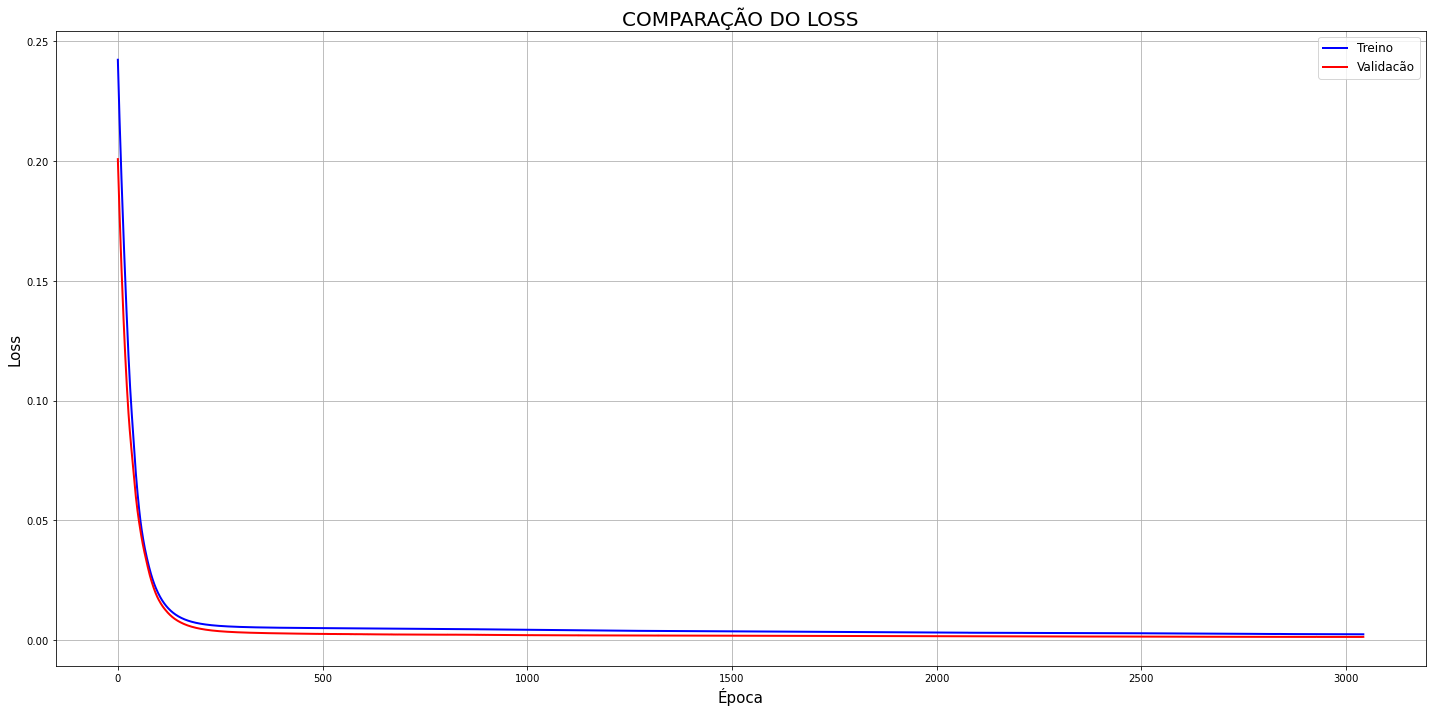

In [19]:
plt.figure(figsize=(20,10))

plt.plot(history.history['loss'], label = "Treino", linewidth =2, color ='blue')        
plt.plot(history.history['val_loss'],'-', label = "Validacão", linewidth =2, color='red')

plt.title('COMPARAÇÃO DO LOSS', fontsize =20)
plt.xlabel('Época', fontsize =15)
plt.ylabel('Loss',fontsize =15)
plt.grid()
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [20]:
modelo.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 120)            113760    
_________________________________________________________________
lstm_1 (LSTM)                (None, 120)               115680    
_________________________________________________________________
dense (Dense)                (None, 30)                3630      
Total params: 233,070
Trainable params: 233,070
Non-trainable params: 0
_________________________________________________________________


In [21]:
import warnings
warnings.filterwarnings("ignore")
y_train_pred =  modelo.predict(x_train_scaled) 
y_train_pred = y_scaler.inverse_transform(y_train_pred)
y_train = y_scaler.inverse_transform(y_train_scaled)
y_train_pred = pd.DataFrame(y_train_pred)
y_train = pd.DataFrame(y_train)

train_metrics = get_metrics(y_train, y_train_pred)
train_metrics

,MSE,RMSE,MAE,Pearson r,Fac2
0,8.29021e+14,2.87927e+07,1.3654e+07,0.957739,0.93508
1,9.99305e+14,3.16118e+07,1.50205e+07,0.948159,0.932802
2,5.20966e+14,2.28247e+07,1.15759e+07,0.973776,0.925968
3,4.28027e+14,2.06888e+07,1.05337e+07,0.978662,0.92369
4,4.2438e+14,2.06005e+07,1.03233e+07,0.978538,0.927107
5,4.83234e+14,2.19826e+07,1.09035e+07,0.975651,0.938497
6,4.73074e+14,2.17503e+07,1.02459e+07,0.975451,0.936219
7,8.47741e+14,2.9116e+07,1.40697e+07,0.955272,0.910023
8,9.77003e+14,3.12571e+07,1.50894e+07,0.947883,0.890661
9,4.92911e+14,2.22016e+07,1.14539e+07,0.974459,0.92369


In [22]:
y_test_pred =  modelo.predict(x_test_scaled) 
y_test_pred = y_scaler.inverse_transform(y_test_pred)
y_test = y_scaler.inverse_transform(y_test_scaled)
y_test_pred = pd.DataFrame(y_test_pred)
y_test = pd.DataFrame(y_test)

test_metrics = get_metrics(y_test, y_test_pred)
test_metrics

,MSE,RMSE,MAE,Pearson r,Fac2
0,9.88626e+15,9.94297e+07,7.5466e+07,0.80902,0.921811
1,9.36479e+15,9.67719e+07,7.18047e+07,0.795544,0.901235
2,1.10535e+16,1.05136e+08,8.07665e+07,0.86407,0.962963
3,5.16693e+15,7.18814e+07,5.47568e+07,0.881148,0.995885
4,3.35226e+15,5.78987e+07,4.54893e+07,0.882827,0.99177
5,3.65586e+15,6.04637e+07,4.7212e+07,0.870053,0.995885
6,4.7956e+15,6.92503e+07,4.96527e+07,0.808519,0.995885
7,5.47985e+15,7.4026e+07,5.88192e+07,0.776042,0.979424
8,6.2882e+15,7.92982e+07,6.29567e+07,0.753754,0.975309
9,3.57531e+15,5.97939e+07,4.70985e+07,0.854832,0.995885


In [23]:
y_val_pred =  modelo.predict(x_val_scaled) 
y_val_pred = y_scaler.inverse_transform(y_val_pred)
y_val = y_scaler.inverse_transform(y_val_scaled)
y_val_pred = pd.DataFrame(y_val_pred)
y_val = pd.DataFrame(y_val)

val_metrics = get_metrics(y_val, y_val_pred)
val_metrics

,MSE,RMSE,MAE,Pearson r,Fac2
0,4.33784e+14,2.08275e+07,1.38289e+07,0.824624,0.916667
1,4.45801e+14,2.1114e+07,1.41769e+07,0.809371,0.9125
2,3.58806e+14,1.89422e+07,1.28559e+07,0.851264,0.916667
3,2.45294e+14,1.56619e+07,1.12075e+07,0.906632,0.941667
4,2.23278e+14,1.49425e+07,1.05686e+07,0.914692,0.979167
5,2.54336e+14,1.59479e+07,1.09527e+07,0.90484,0.975
6,2.23984e+14,1.49661e+07,1.03022e+07,0.914188,0.983333
7,4.45388e+14,2.11042e+07,1.41885e+07,0.81115,0.908333
8,4.56995e+14,2.13774e+07,1.4795e+07,0.800421,0.904167
9,2.97528e+14,1.7249e+07,1.19719e+07,0.877402,0.925


In [24]:
 bahia = regions_test[regions_test['Country/Region'] == 'BA'].copy()
x_bahia, y_bahia = generate_regions_dataset(
    key="Country/Region",
    regions_data=bahia,
    look_back=lookback,
    look_forward=lookforward,
    x_columns=x_columns,
    y_columns=y_columns
)

In [25]:
local="Bahia_"
y_bahia_scaled = y_scaler.transform(y_bahia)

x_bahia_scaled = create_dataset(model_confirmed, model_deaths, normalizador_confirmed,normalizador_deaths,x_scaler,x_bahia)
x_bahia_scaled = np.reshape(x_bahia_scaled, (x_bahia_scaled.shape[0], 1 , x_bahia_scaled.shape[1]))

y_bahia_pred = modelo.predict(x_bahia_scaled)
y_bahia_pred = y_scaler.inverse_transform(y_bahia_pred)

y_bahia = y_scaler.inverse_transform(y_bahia_scaled)

y_bahia_pred = pd.DataFrame(y_bahia_pred)
y_bahia = pd.DataFrame(y_bahia)

bahia_metrics = get_metrics(y_bahia, y_bahia_pred)
bahia_metrics

,MSE,RMSE,MAE,Pearson r,Fac2
0,2.98342e+15,5.46207e+07,4.33107e+07,0.434547,0.950413
1,3.14454e+15,5.60762e+07,4.41198e+07,0.370955,0.92562
2,2.58156e+15,5.08091e+07,3.87891e+07,0.629052,0.983471
3,2.26067e+15,4.75465e+07,3.8447e+07,0.667669,0.991736
4,1.96831e+15,4.43657e+07,3.56848e+07,0.713511,0.983471
5,2.07696e+15,4.55736e+07,3.72728e+07,0.700193,0.991736
6,1.65397e+15,4.06691e+07,3.13292e+07,0.712419,0.991736
7,2.74477e+15,5.23905e+07,4.36123e+07,0.428934,0.958678
8,2.77675e+15,5.26948e+07,4.36748e+07,0.397979,0.958678
9,2.08402e+15,4.5651e+07,3.51146e+07,0.645337,0.991736


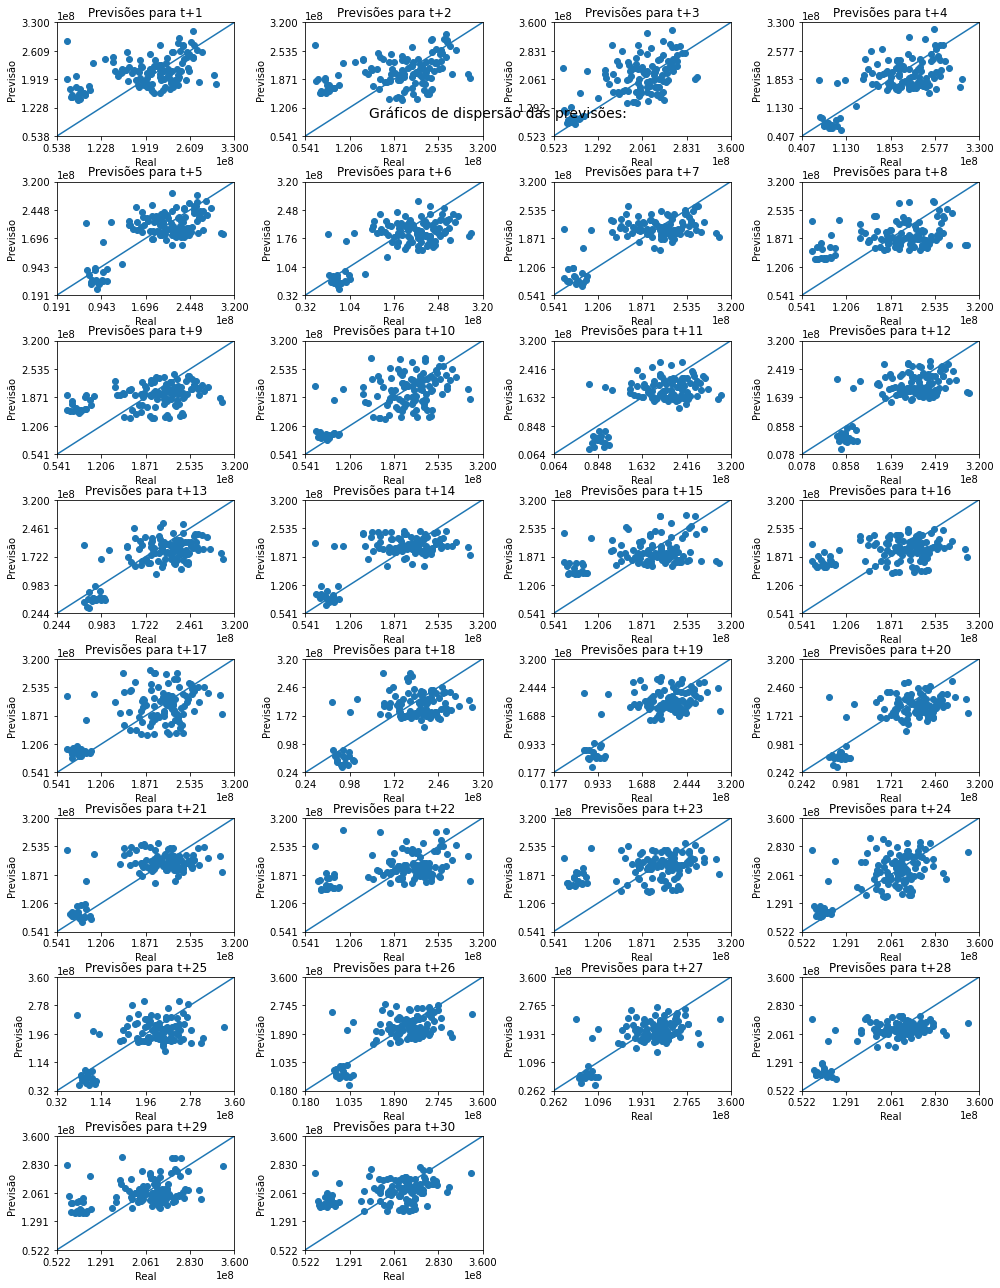

In [26]:
plot_scatter(
    y_bahia,
    y_bahia_pred,
    title='Gráficos de dispersão das previsões: ',
)

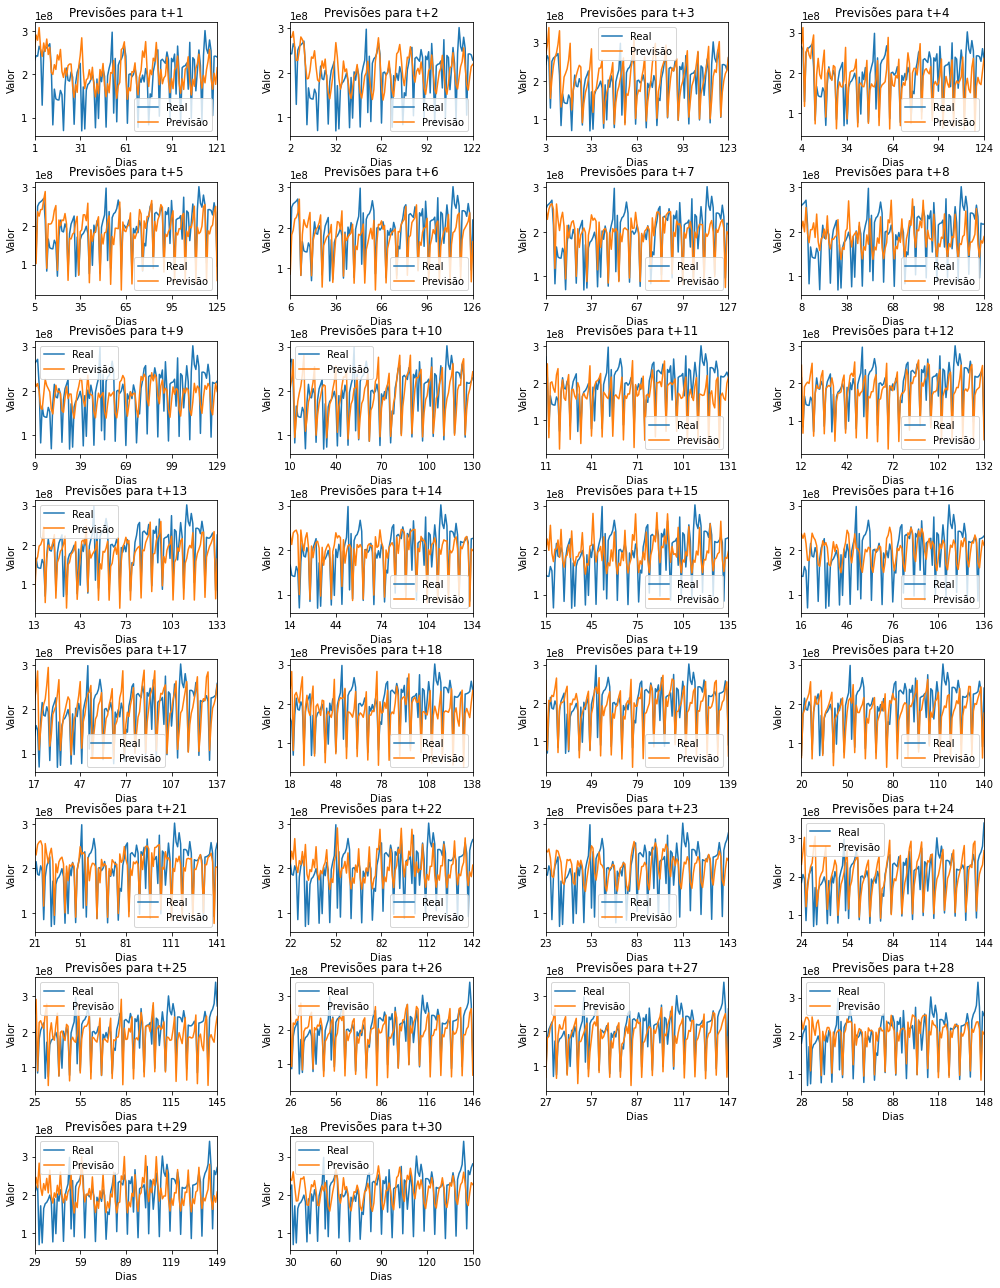

In [27]:
plot_samples(
    y_bahia,
    y_bahia_pred,
    xlabel='Dias',
    ylabel='Valor'
)

#### K-FOLD

In [28]:
train_x, train_y = generate_regions_dataset("Country/Region", dados, lookback, lookforward, x_columns, y_columns=y_columns)

In [29]:
from sklearn.model_selection import KFold

In [30]:
import warnings
warnings.filterwarnings('ignore')

kfold = KFold(n_splits=5, shuffle=True)
MSEscores = []
RMSEscores = []
MAEscores = []
FACscores = []
Rscores = []

num_k = 0
for train, test in kfold.split(train_x, train_y):
    normalizador_kfold = MinMaxScaler(feature_range=(0, 1))
    normalizador_kfold.fit(train_x.iloc[train])
    
    normalizador_kfold_y = MinMaxScaler(feature_range=(0, 1))
    y_kfold_train = normalizador_kfold_y.fit_transform(train_y.iloc[train])
    
    y_kfold_test = normalizador_kfold_y.transform(train_y.iloc[test])
    
    new_kfold_train = create_dataset(model_confirmed, model_deaths, normalizador_confirmed, normalizador_deaths, normalizador_kfold, train_x.iloc[train])
    new_kfold_train = np.reshape(new_kfold_train, (new_kfold_train.shape[0], 1 , new_kfold_train.shape[1]))
    
    new_kfold_test = create_dataset(model_confirmed, model_deaths, normalizador_confirmed, normalizador_deaths, normalizador_kfold, train_x.iloc[test])
    new_kfold_test = np.reshape(new_kfold_test, (new_kfold_test.shape[0], 1 , new_kfold_test.shape[1]))
            
    kfold_train = new_kfold_train
    kfold_test = new_kfold_test
    
    #Arquitetura da RNA
    activation = 'relu'
    opt = optimizers.Adamax()

    tf.random.set_seed(0)

    modelo = Sequential()
    modelo.add(LSTM(units = 120, return_sequences = True, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.001), input_shape = (new_kfold_train.shape[1],new_kfold_train.shape[2])))
    modelo.add(LSTM(units = 120, activation = 'relu'))
    modelo.add(Dense(units = lookforward, activation = 'linear'))

    modelo.compile(optimizer=opt, loss='mse')

    modelo.fit(kfold_train, y_kfold_train, shuffle=False ,batch_size = 1500, epochs = 3043, verbose=0)
    
    observado = y_kfold_test
    predicao =  modelo.predict(kfold_test)
    predicao = normalizador_kfold_y.inverse_transform(predicao)
    observado = normalizador_kfold_y.inverse_transform(observado)
    
    metricas_qualidade = get_metrics(pd.DataFrame(observado), pd.DataFrame(predicao), filename="K_FOLD_SEM_INFERENCIA_CONFIRMED_LSTMCNN")
    MSE = metricas_qualidade["MSE"].mean()
    RMSE = metricas_qualidade["RMSE"].mean()
    MAE = metricas_qualidade["MAE"].mean()
    R = metricas_qualidade["Pearson r"].mean()
    FAC2 = metricas_qualidade["Fac2"].mean()
    
    print("K: " + str(num_k))
    print("MSE: ", MSE)
    print("RMSE: ", RMSE)
    print("MAE: ", MAE)
    print("R: ", R)
    print("FAC2: ", FAC2)
    print("-----------------------------------")
    MSEscores.append(MSE)
    RMSEscores.append(RMSE)
    MAEscores.append(MAE)
    Rscores.append(R)
    FACscores.append(FAC2)
    num_k = num_k + 1
    
print("RESULTS K-FOLD: ")
print("MSE: " + str(np.mean(MSEscores)) + " +/- " +  str(np.std(MSEscores)))
print("RMSE: " + str(np.mean(RMSEscores)) + " +/- " +  str(np.std(RMSEscores)))
print("MAE: " + str(np.mean(MAEscores)) + " +/- " +  str(np.std(MAEscores)))
print("R: " + str(np.mean(Rscores)) + " +/- " +  str(np.std(Rscores)))
print("FAC2: " + str(np.mean(FACscores)) + " +/- " +  str(np.std(FACscores)))

K: 0
MSE:  821452895525079.2
RMSE:  28116706.23879126
MAE:  16422239.42052935
R:  0.9678545371624511
FAC2:  0.920879120879121
-----------------------------------
K: 1
MSE:  779626287716162.6
RMSE:  27576267.913573943
MAE:  15272207.492518665
R:  0.9738351533702515
FAC2:  0.9295343137254902
-----------------------------------
K: 2
MSE:  1230571027782957.2
RMSE:  34375631.50057974
MAE:  19555184.211832546
R:  0.9664129518257601
FAC2:  0.9352941176470587
-----------------------------------
K: 3
MSE:  729020278616195.8
RMSE:  26405283.556729436
MAE:  14300893.837486763
R:  0.9740436083488915
FAC2:  0.9425245098039216
-----------------------------------
K: 4
MSE:  935287258357274.8
RMSE:  30050508.901345212
MAE:  16801234.940545704
R:  0.9729282138711131
FAC2:  0.9302696078431371
-----------------------------------
RESULTS K-FOLD: 
MSE: 899191549599534.0 +/- 179115979413604.06
RMSE: 29304879.622203924 +/- 2795567.899556106
MAE: 16470351.980582606 +/- 1775955.3539157547
R: 0.9710148929156934

#### TREINAMENTO COM DADOS COMPLETOS

In [31]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

x_scaler.fit(train_x)

y_train_scaled = y_scaler.fit_transform(train_y)

#### SALVANDO O NORMALIZADOR
dump(x_scaler, open('Xscaler_Valor.pkl', 'wb'))
dump(y_scaler, open('Yscaler_Valor.pkl', 'wb'))

In [32]:
x_train_scaled = create_dataset(model_confirmed, model_deaths, normalizador_confirmed, normalizador_deaths,x_scaler,train_x)

In [33]:
x_train_scaled = np.reshape(x_train_scaled, (x_train_scaled.shape[0], 1 , x_train_scaled.shape[1]))

In [34]:
#Arquitetura da RNA
activation = 'relu'
opt = optimizers.Adamax()

tf.random.set_seed(0)

modelo = Sequential()
modelo.add(LSTM(units = 120, return_sequences = True, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.001), input_shape = (x_train_scaled.shape[1],x_train_scaled.shape[2])))
modelo.add(LSTM(units = 120, activation = 'relu'))
modelo.add(Dense(units = lookforward, activation = 'linear'))

modelo.compile(optimizer=opt, loss='mse')

history = modelo.fit(x_train_scaled, y_train_scaled, shuffle=False ,batch_size = 1500, epochs = 3043, verbose=1)

Train on 1361 samples
Epoch 1/3043
1361/1361 [==============================] - 3s 2ms/sample - loss: 0.2746
Epoch 2/3043
1361/1361 [==============================] - 0s 36us/sample - loss: 0.2679
Epoch 3/3043
1361/1361 [==============================] - 0s 43us/sample - loss: 0.2615
Epoch 4/3043
1361/1361 [==============================] - 0s 28us/sample - loss: 0.2553
Epoch 5/3043
1361/1361 [==============================] - 0s 46us/sample - loss: 0.2494
Epoch 6/3043
1361/1361 [==============================] - 0s 38us/sample - loss: 0.2435
Epoch 7/3043
1361/1361 [==============================] - 0s 45us/sample - loss: 0.2378
Epoch 8/3043
1361/1361 [==============================] - 0s 43us/sample - loss: 0.2323
Epoch 9/3043
1361/1361 [==============================] - 0s 31us/sample - loss: 0.2268
Epoch 10/3043
1361/1361 [==============================] - 0s 29us/sample - loss: 0.2214
Epoch 11/3043
1361/1361 [==============================] - 0s 25us/sample - loss: 0.2161
Epoch 12/

In [35]:
modelo.save('LSTM_NotasFiscais_Valor.h5')

In [36]:
import warnings
warnings.filterwarnings("ignore")
y_train_pred =  modelo.predict(x_train_scaled) 
y_train_pred = y_scaler.inverse_transform(y_train_pred)
y_train = y_scaler.inverse_transform(y_train_scaled)
y_train_pred = pd.DataFrame(y_train_pred)
y_train = pd.DataFrame(y_train)

train_metrics = get_metrics(y_train, y_train_pred)
train_metrics

,MSE,RMSE,MAE,Pearson r,Fac2
0,1.27676e+15,3.57318e+07,2.02259e+07,0.958713,0.928729
1,1.18139e+15,3.43713e+07,2.03383e+07,0.961739,0.953711
2,6.89723e+14,2.62626e+07,1.46065e+07,0.977935,0.930933
3,6.18803e+14,2.48757e+07,1.40765e+07,0.980141,0.936076
4,5.98689e+14,2.44681e+07,1.35051e+07,0.980713,0.945628
5,6.27951e+14,2.5059e+07,1.39786e+07,0.97982,0.947832
6,6.36786e+14,2.52346e+07,1.36848e+07,0.979239,0.934607
7,1.28737e+15,3.58799e+07,2.01442e+07,0.957302,0.928729
8,1.20739e+15,3.47475e+07,2.05971e+07,0.959861,0.935342
9,6.88822e+14,2.62454e+07,1.5041e+07,0.977336,0.918442


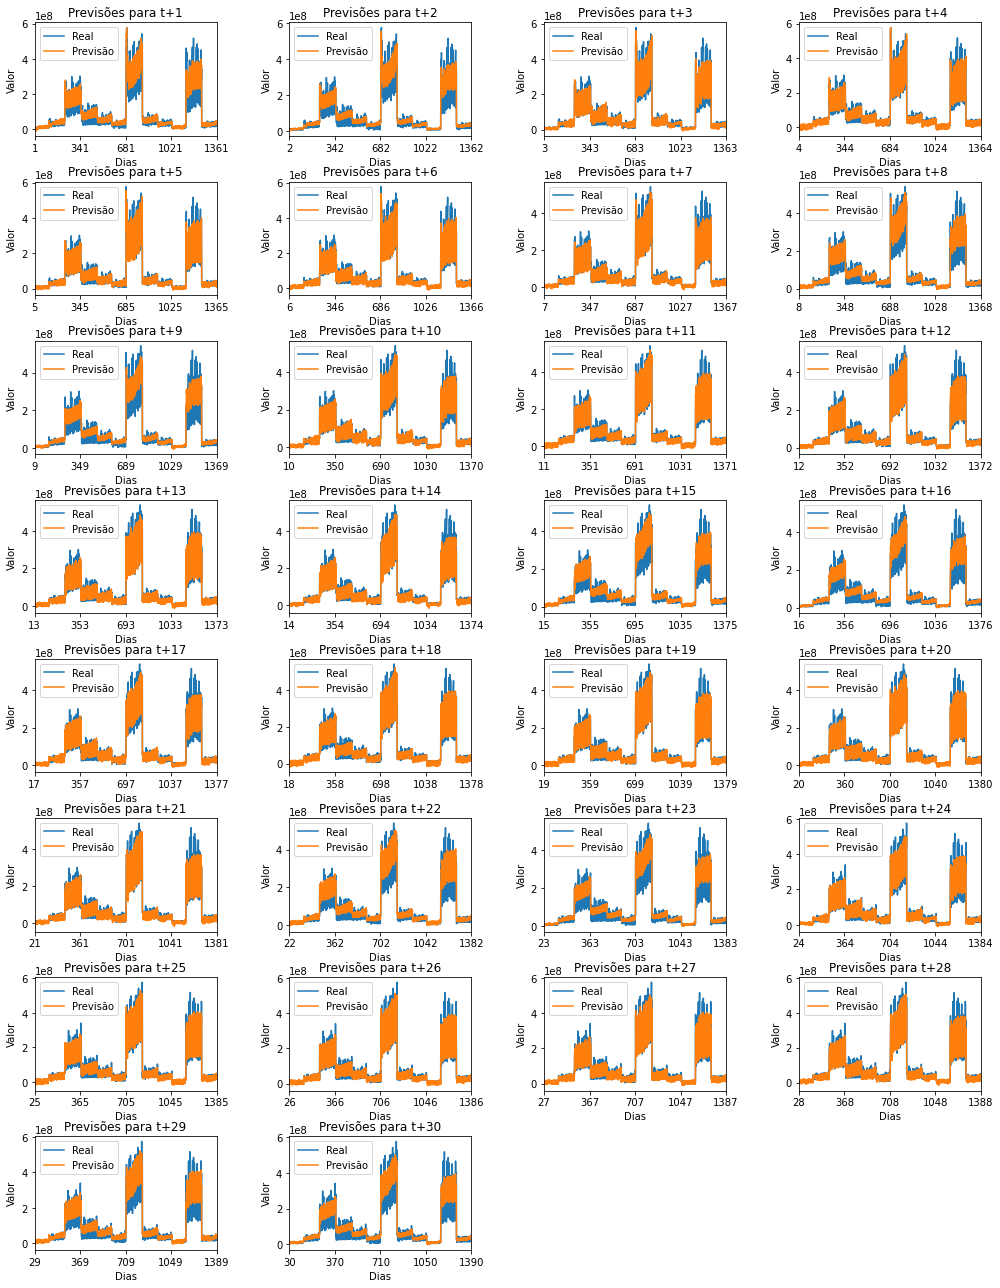

In [37]:
plot_samples(
    y_train,
    y_train_pred,
    xlabel='Dias',
    ylabel='Valor'
)